In [1]:
import torch
from torch.nn import ModuleList
from gpytorch.module import Module

from abc import abstractmethod


def default_postprocess_script(x):
    return x



class Distance1(torch.nn.Module):
    def __init__(self, postprocess_script=default_postprocess_script):
        super().__init__()
        self._postprocess = postprocess_script

    def _sq_dist(self, x1, x2, postprocess, x1_eq_x2=False):
        
        res = torch.mul(torch.unsqueeze(x1, 1), torch.unsqueeze(x2, 0))

        if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
            pass
#             res.diagonal(dim1=-2, dim2=-1).fill_(0)

        # Zero out negative values
        res.clamp_min_(0)
        return self._postprocess(res) if postprocess else res

    def _dist(self, x1, x2, postprocess, x1_eq_x2=False):
        # TODO: use torch cdist once implementation is improved: https://github.com/pytorch/pytorch/pull/25799
        res = self._sq_dist(x1, x2, postprocess=False, x1_eq_x2=x1_eq_x2)
        res = res.clamp_min_(1e-30).sqrt_()
        return self._postprocess(res) if postprocess else res




class Kernel(Module):

    has_lengthscale = False

    def __init__(
        self,
        ard_num_dims=None,
        batch_shape=torch.Size([]),
        active_dims=None,
        lengthscale_prior=None,
        lengthscale_constraint=None,
        eps=1e-6,
        **kwargs,
    ):
        super(Kernel, self).__init__()
        self._batch_shape = batch_shape
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.register_buffer("active_dims", active_dims)
        self.ard_num_dims = ard_num_dims

        self.eps = eps

        param_transform = kwargs.get("param_transform")

        if lengthscale_constraint is None:
            lengthscale_constraint = Positive()

        if param_transform is not None:
            warnings.warn(
                "The 'param_transform' argument is now deprecated. If you want to use a different "
                "transformation, specify a different 'lengthscale_constraint' instead.",
                DeprecationWarning,
            )

        if self.has_lengthscale:
            lengthscale_num_dims = 1 if ard_num_dims is None else ard_num_dims
            self.register_parameter(
                name="raw_lengthscale",
                parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, lengthscale_num_dims)),
            )
            if lengthscale_prior is not None:
                self.register_prior(
                    "lengthscale_prior", lengthscale_prior, lambda m: m.lengthscale, lambda m, v: m._set_lengthscale(
                        v)
                )

            self.register_constraint("raw_lengthscale", lengthscale_constraint)

        self.distance_module = None
        # TODO: Remove this on next official PyTorch release.
        self.__pdist_supports_batch = True

    @abstractmethod
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        raise NotImplementedError()

    @property
    def batch_shape(self):
        kernels = list(self.sub_kernels())
        if len(kernels):
            return _mul_broadcast_shape(self._batch_shape, *[k.batch_shape for k in kernels])
        else:
            return self._batch_shape

    @batch_shape.setter
    def batch_shape(self, val):
        self._batch_shape = val

    @property
    def dtype(self):
        if self.has_lengthscale:
            return self.lengthscale.dtype
        else:
            for param in self.parameters():
                return param.dtype
            return torch.get_default_dtype()

    @property
    def is_stationary(self) -> bool:
        """
        Property to indicate whether kernel is stationary or not.
        """
        return self.has_lengthscale

    @property
    def lengthscale(self):
        if self.has_lengthscale:
            return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)
        else:
            return None

    @lengthscale.setter
    def lengthscale(self, value):
        self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not self.has_lengthscale:
            raise RuntimeError("Kernel has no lengthscale.")

        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)

        self.initialize(
            raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    def local_load_samples(self, samples_dict, memo, prefix):
        num_samples = next(iter(samples_dict.values())).size(0)
        self.batch_shape = torch.Size([num_samples]) + self.batch_shape
        super().local_load_samples(samples_dict, memo, prefix)

    def covar_dist(
        self,
        x1,
        x2,
        diag=False,
        last_dim_is_batch=False,
        square_dist=True,
        dist_postprocess_func=default_postprocess_script,
        postprocess=True,
        **params,
    ):

        if last_dim_is_batch:
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)

        # torch scripts expect tensors
        postprocess = torch.tensor(postprocess)

        res = None

        # Cache the Distance object or else JIT will recompile every time
        if not self.distance_module or self.distance_module._postprocess != dist_postprocess_func:
            self.distance_module = Distance1(dist_postprocess_func)

        if diag:
            # Special case the diagonal because we can return all zeros most of
            # the time.
            if x1_eq_x2:
                res = torch.zeros(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                if postprocess:
                    res = dist_postprocess_func(res)
                return res
            else:
                res = torch.norm(x1 - x2, p=2, dim=-1)
                if square_dist:
                    res = res.pow(2)
            if postprocess:
                res = dist_postprocess_func(res)
            return res

        elif square_dist:
            res = self.distance_module._sq_dist(x1, x2, postprocess, x1_eq_x2)
        else:
            res = self.distance_module._dist(x1, x2, postprocess, x1_eq_x2)

        return res

    def named_sub_kernels(self):
        for name, module in self.named_modules():
            if module is not self and isinstance(module, Kernel):
                yield name, module

    def num_outputs_per_input(self, x1, x2):
        """
        How many outputs are produced per input (default 1)
        if x1 is size `n x d` and x2 is size `m x d`, then the size of the kernel
        will be `(n * num_outputs_per_input) x (m * num_outputs_per_input)`
        Default: 1
        """
        return 1

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return exact_prediction_strategies.DefaultPredictionStrategy(
            train_inputs, train_prior_dist, train_labels, likelihood
        )

    def sub_kernels(self):
        for _, kernel in self.named_sub_kernels():
            yield kernel

    def __call__(self, x1, x2=None, diag=False, last_dim_is_batch=False, **params):
        x1_, x2_ = x1, x2

        # Select the active dimensions
        if self.active_dims is not None:
            x1_ = x1_.index_select(-1, self.active_dims)
            if x2_ is not None:
                x2_ = x2_.index_select(-1, self.active_dims)

        # Give x1_ and x2_ a last dimension, if necessary
        if x1_.ndimension() == 1:
            x1_ = x1_.unsqueeze(1)
        if x2_ is not None:
            if x2_.ndimension() == 1:
                x2_ = x2_.unsqueeze(1)
            if not x1_.size(-1) == x2_.size(-1):
                raise RuntimeError(
                    "x1_ and x2_ must have the same number of dimensions!")

        if x2_ is None:
            x2_ = x1_

        # Check that ard_num_dims matches the supplied number of dimensions
        if settings.debug.on():
            if self.ard_num_dims is not None and self.ard_num_dims != x1_.size(-1):
                raise RuntimeError(
                    "Expected the input to have {} dimensionality "
                    "(based on the ard_num_dims argument). Got {}.".format(
                        self.ard_num_dims, x1_.size(-1))
                )

        if diag:
            res = super(Kernel, self).__call__(x1_, x2_, diag=True,
                                               last_dim_is_batch=last_dim_is_batch, **params)
            # Did this Kernel eat the diag option?
            # If it does not return a LazyEvaluatedKernelTensor, we can call
            # diag on the output
            if not isinstance(res, LazyEvaluatedKernelTensor):
                if res.dim() == x1_.dim() and res.shape[-2:] == torch.Size((x1_.size(-2), x2_.size(-2))):
                    res = res.diag()
            return res

        else:
            if settings.lazily_evaluate_kernels.on():
                res = LazyEvaluatedKernelTensor(
                    x1_, x2_, kernel=self, last_dim_is_batch=last_dim_is_batch, **params)
            else:
                res = lazify(super(Kernel, self).__call__(
                    x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
            return res

    def __getstate__(self):
        # JIT ScriptModules cannot be pickled
        self.distance_module = None
        return self.__dict__

    def __add__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, AdditiveKernel) else [self]
        kernels += other.kernels if isinstance(other,
                                               AdditiveKernel) else [other]
        return AdditiveKernel(*kernels)

    def __mul__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, ProductKernel) else [self]
        kernels += other.kernels if isinstance(other,
                                               ProductKernel) else [other]
        return ProductKernel(*kernels)

    def __setstate__(self, d):
        self.__dict__ = d

    def __getitem__(self, index):
        if len(self.batch_shape) == 0:
            return self

        new_kernel = deepcopy(self)
        # Process the index
        index = index if isinstance(index, tuple) else (index,)

        for param_name, param in self._parameters.items():
            new_kernel._parameters[param_name].data = param.__getitem__(index)
            ndim_removed = len(param.shape) - \
                len(new_kernel._parameters[param_name].shape)
            new_batch_shape_len = len(self.batch_shape) - ndim_removed
            new_kernel.batch_shape = new_kernel._parameters[
                param_name].shape[:new_batch_shape_len]

        for sub_module_name, sub_module in self.named_sub_kernels():
            self._modules[sub_module_name] = sub_module.__getitem__(index)

        return new_kernel


### Preparation

In [2]:
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import GPUtil

In [3]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 37% |  2% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 | 54% |  3% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 2 GPUs.


In [5]:
alpha = 4
l = 3
alphabet = list(range(alpha))

# prob no mutation at time 1
q = 1 - 1/l

odds = torch.tensor([q**t/(1 - q**t) for t in range(1, l+1)]).to(output_device)

In [6]:
seqs = list(itertools.product(alphabet, repeat=l))
seqs = torch.tensor(seqs).to(output_device)

In [18]:
seqs1h_test = torch.flatten(F.one_hot(seqs), start_dim=1).to(output_device).type(torch.float32)

In [19]:
x1 = seqs1h_test[:10]
x2 = seqs1h_test[10:30]

### Build Kernel

In [20]:
## Inverse for eigenvalue matrix for calculate K = \sum b_k P'^k

scaling_factors = np.array([(1 - q**t)**l for t in range(l+1)])
scaling_factors[0] = 1
eigvals = np.array([[np.exp(-k*t) for t in range(l+1)] for k in range(l+1)])
eigvals = eigvals*scaling_factors

coeffs = np.linalg.inv(eigvals)
coeffs = torch.tensor(coeffs, dtype=torch.float32).to(output_device)

In [21]:
scaling_factors = torch.tensor([(1 - q**t)**l for t in range(l+1)]).to(output_device)
scaling_factors[0] = 1

In [22]:
import gpytorch
from gpytorch import settings
from gpytorch.constraints import Positive
from gpytorch.lazy import LazyEvaluatedKernelTensor, ZeroLazyTensor, delazify, lazify
from gpytorch.models import exact_prediction_strategies
from gpytorch.module import Module
from gpytorch.utils.broadcasting import _mul_broadcast_shape

In [23]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class SkewKernel(Kernel):
    """Diploid kernel"""

    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, alpha, l, odds,
                log_lda_prior=None, log_lda_constraint=None, 
                log_p_prior=None, log_p_constraint=None,
                **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
          name='raw_log_p', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l, alpha))
        )

        self.register_parameter(
          name='raw_log_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l+1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if log_lda_constraint is None:
          log_lda_constraint = LessThan(upper_bound=0.)

        if log_p_constraint is None:
          log_p_constraint = LessThan(upper_bound=0.)

        # register the constraint
        self.register_constraint("raw_log_lda", log_lda_constraint)
        self.register_constraint("raw_log_p", log_p_constraint)


    # now set up the 'actual' paramter
    @property
    def log_lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_lda_constraint.transform(self.raw_log_lda)

    @property
    def log_p(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_p_constraint.transform(self.raw_log_p)

    @log_lda.setter
    def log_lda(self, value):
      return self._set_log_lda(value)

    @log_p.setter
    def log_p(self, value):
      return self._set_log_p(value)



#     def forward(self, x1, x2, **params):
#         # construct masks used for calculate rates
#         masks = self.covar_dist(x1, x2)
#         ps = torch.softmax(self.log_p, axis=1)

#         rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
#         rates = rates/ps
#         rates = rates.to(output_device)
#         rates = torch.flatten(rates, start_dim=1)
#         log_rates = torch.log(rates)
        

#         out = torch.mul(masks.unsqueeze(2), log_rates)
#         out = torch.flatten(out, start_dim=3)
# #         out[out==0.] = 1.

#         powers_nz = torch.exp(torch.sum(out, -1))
#         power_0 = F.relu(torch.sum(masks, -1) - l + 1)
#         powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)

#         weights = torch.matmul(coeffs.to(output_device), torch.exp(self.log_lda))
        
#         return torch.sum(torch.mul(powers, weights), -1)
    
    def func(self, x1, x2, **params):
        # construct masks used for calculate rates
        masks = self.covar_dist(x1, x2)
        ps = torch.softmax(self.log_p, axis=1)
        
        pi = x2*(torch.flatten(ps))
        pi[pi==0.] = 1
        pi = torch.prod(pi, 1)
        Dpi = torch.diag(pi)        

        rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
        rates = rates/ps
        rates = rates.to(output_device)
        rates = torch.flatten(rates, start_dim=1)
        log_rates = torch.log(rates)
        

        out = torch.mul(masks.unsqueeze(2), log_rates)
        out = torch.flatten(out, start_dim=3)
#         out[out==0.] = 1.

        powers_nz = torch.exp(torch.sum(out, -1))
        power_0 = F.relu(torch.sum(masks, -1) - l + 1).matmul(torch.linalg.inv(Dpi))
        powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)
        powers = powers*scaling_factors
        
        return powers_nz, powers, rates

    
    def forward(self, x1, x2, **params):
        # construct masks used for calculate rates
        masks = self.covar_dist(x1, x2)
        ps = torch.softmax(self.log_p, axis=1)
        
        pi = x2*(torch.flatten(ps))
        pi[pi==0.] = 1
        pi = torch.prod(pi, 1)
        Dpi = torch.diag(pi)        

        rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
        rates = rates/ps
        rates = rates.to(output_device)
        rates = torch.flatten(rates, start_dim=1)
        log_rates = torch.log(rates)
        

        out = torch.mul(masks.unsqueeze(2), log_rates)
        out = torch.flatten(out, start_dim=3)
#         out[out==0.] = 1.

        powers_nz = torch.exp(torch.sum(out, -1))
        power_0 = F.relu(torch.sum(masks, -1) - l + 1).matmul(torch.linalg.inv(Dpi))
        powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)
        powers = powers*scaling_factors
        
        weights = torch.matmul(coeffs.to(output_device), torch.exp(self.log_lda))
        
        return torch.sum(torch.mul(powers, weights), -1)

In [24]:
kernel = SkewKernel(alpha, l, odds).to(output_device)

In [25]:
seqs1h_test.shape

torch.Size([64, 12])

In [26]:
powers_nz, powers, rates = kernel.func(seqs1h_test, seqs1h_test)

#### Eigenvals

In [28]:
def get_ev(M):
    return torch.sort(torch.eig(M)[0][:,0].unique(), descending=True)[0]

In [31]:
t=1

Pp = powers[:,:,t].matmul(Dpi)

NameError: name 'Dpi' is not defined

In [32]:
# Eigenvalues of (P')^t NOTE: without multiplication by Dp^-1

eigvals = np.array([[q**(k*t) for t in range(l+1)] for k in range(l+1)])
eigvals = eigvals

coeffs = np.linalg.inv(eigvals)
coeffs = torch.tensor(coeffs, dtype=torch.float32).to(output_device)

In [33]:
get_ev(powers[:,:,3].matmul(Dpi))

NameError: name 'Dpi' is not defined

In [836]:
matweighted = torch.stack([coeffs[t,1]*powers[:,:,t].matmul(Dpi) for t in range(l+1)])

In [837]:
matweighted.shape

torch.Size([4, 64, 64])

In [838]:
lincomb = torch.sum(matweighted, 0)

In [839]:
get_ev(lincomb)

tensor([ 9.9997e-01,  9.9997e-01,  9.9997e-01,  9.9997e-01,  9.9997e-01,
         9.9997e-01,  9.9997e-01,  9.9997e-01,  3.3503e-03,  4.7199e-04,
         4.7199e-04,  4.7198e-04,  4.7198e-04,  4.7198e-04,  4.7197e-04,
         4.7197e-04,  4.7197e-04,  4.7196e-04,  4.7196e-04,  4.7196e-04,
         4.7195e-04,  4.7195e-04,  4.7195e-04,  4.7194e-04,  4.7194e-04,
         4.7188e-04, -4.7565e-04, -4.7566e-04, -4.7566e-04, -4.7567e-04,
        -4.7568e-04, -4.7568e-04, -4.7568e-04, -4.7568e-04, -4.7568e-04,
        -4.7569e-04, -4.7569e-04, -4.7569e-04, -4.7569e-04, -4.7570e-04,
        -4.7570e-04, -4.7570e-04, -4.7570e-04, -4.7571e-04, -4.7571e-04,
        -4.7576e-04], device='cuda:0', grad_fn=<SortBackward0>)

In [805]:
get_ev(powers[:,:,0] + powers[:,:,1] + powers[:,:,2] + powers[:,:,3] )/64

tensor([3.0002, 1.4077, 1.4077, 1.4077, 1.4077, 1.4077, 1.4077, 1.4077, 1.4077,
        0.7300, 0.7300, 0.7300, 0.7300, 0.7300, 0.7300, 0.7300, 0.7300, 0.7300,
        0.7300, 0.7300, 0.7300, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103,
        0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103], device='cuda:0',
       grad_fn=<DivBackward0>)

In [779]:
np.sum(eigvals, 0)

array([4.        , 2.40740741, 1.7297668 , 1.41010009])

In [825]:
get_ev((powers[:,:,0] + powers[:,:,1]))

tensor([64.0156, 42.6823, 42.6823, 42.6823, 42.6823, 42.6823, 42.6823, 42.6823,
        28.4601, 28.4601, 28.4601, 28.4601, 28.4601, 28.4601, 28.4601, 28.4601,
        28.4601, 28.4601, 28.4601, 28.4601, 28.4601, 28.4601, 18.9786, 18.9786,
        18.9786, 18.9786, 18.9786, 18.9786, 18.9786, 18.9786, 18.9786, 18.9786,
        18.9786, 18.9786, 18.9786], device='cuda:0', grad_fn=<SortBackward0>)

In [826]:
eigvals[0] + eigvals[1]

array([2.        , 1.66666667, 1.44444444, 1.2962963 ])

In [765]:
a = torch.rand(2,3,2)

In [766]:
a[0] + a[1]

tensor([[1.1353, 0.2600],
        [1.4475, 1.6111],
        [0.9237, 1.2101]])

In [767]:
torch.sum(a, 0)

tensor([[1.1353, 0.2600],
        [1.4475, 1.6111],
        [0.9237, 1.2101]])

In [730]:
get_ev(powers[:,:,1].matmul(Dpi))

tensor([1.0000, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.4445,
        0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445,
        0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.2963,
        0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963, 0.2963,
        0.2963, 0.2963, 0.2963, 0.2963], device='cuda:0',
       grad_fn=<SortBackward0>)

In [731]:
get_ev(powers[:,:,2].matmul(Dpi))

tensor([1.0001, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.4445, 0.1975, 0.1975,
        0.1975, 0.1975, 0.1975, 0.1975, 0.1975, 0.1975, 0.1975, 0.1975, 0.1975,
        0.1975, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878,
        0.0878, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878, 0.0878],
       device='cuda:0', grad_fn=<SortBackward0>)

In [718]:
get_ev(powers[:,:,1] + powers[:,:,2])

tensor([128.0000,  71.1112,  71.1111,  71.1111,  71.1111,  71.1111,  71.1111,
         71.1111,  71.1111,  41.0865,  41.0864,  41.0864,  41.0864,  41.0864,
         41.0864,  41.0864,  41.0864,  41.0864,  41.0864,  41.0864,  41.0864,
         24.5816,  24.5816,  24.5816,  24.5816,  24.5816,  24.5816,  24.5816,
         24.5816,  24.5816,  24.5816,  24.5816,  24.5816,  24.5816,  24.5816],
       device='cuda:0', grad_fn=<SortBackward0>)

In [724]:
get_ev(torch.sum(powers*coeffs[:,1], -1))

tensor([-238.4003, -238.4003, -238.4003, -238.4004, -238.4004, -238.4004,
        -238.4005, -238.4005, -302.3997, -302.3998, -302.3999, -302.4000,
        -302.4000, -302.4000, -302.4001, -302.4001, -302.4001, -302.4002,
        -302.4002, -302.4002, -302.4003, -302.4003, -302.4008],
       device='cuda:0', grad_fn=<SortBackward0>)

#### Stationary distribution

In [34]:
ps = torch.flatten(F.softmax(kernel.log_p, 1))


pi = seqs1h_test*ps
pi[seqs1h_test*ps==0.] = 1
pi = torch.prod(pi, 1)

Dpi = torch.diag(pi)

In [35]:
eigvals = np.array([[q**(k*t) for t in range(l+1)] for k in range(l+1)])
# eigvals = scaling_factors*eigvals
eigvals = torch.tensor(eigvals, dtype=torch.float32).to(output_device)

In [36]:
coeffs = torch.linalg.inv(eigvals)

In [37]:
eigvals

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.6667, 0.4444, 0.2963],
        [1.0000, 0.4444, 0.1975, 0.0878],
        [1.0000, 0.2963, 0.0878, 0.0260]], device='cuda:0')

In [38]:
power_normed = powers[:,:,1].matmul(Dpi)

In [39]:
power_normed

tensor([[0.4219, 0.0469, 0.0469,  ..., 0.0006, 0.0006, 0.0006],
        [0.0469, 0.4219, 0.0469,  ..., 0.0052, 0.0006, 0.0006],
        [0.0469, 0.0469, 0.4219,  ..., 0.0006, 0.0052, 0.0006],
        ...,
        [0.0006, 0.0052, 0.0006,  ..., 0.4219, 0.0469, 0.0469],
        [0.0006, 0.0006, 0.0052,  ..., 0.0469, 0.4219, 0.0469],
        [0.0006, 0.0006, 0.0006,  ..., 0.0469, 0.0469, 0.4219]],
       device='cuda:0', grad_fn=<MmBackward>)

In [40]:
torch.eig(power_normed)

/scratch/local/46268066/ipykernel_88991/669831905.py:1: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  torch.eig(power_normed)


torch.return_types.eig(
eigenvalues=tensor([[1.0000, 0.0000],
        [0.6667, 0.0000],
        [0.6667, 0.0000],
        [0.6667, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.2963, 0.0000],
        [0.6667, 0.0000],
        [0.6667, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.6667, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.6667, 0.0000],
        [0.6667, 0.0000],
        [0.6667, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.4445, 0.0000],
        [0.4445, 0.0000],
        [0.2963, 0.0000],
        [0.2963, 0.0000],
        [0.4445, 0.0000],
  

### Test kernel properties

In [41]:
kernel = SkewKernel(alpha, l, odds)
kernel = kernel.to(output_device)

In [42]:
seqs1h_test = torch.tensor(seqs1h_test, dtype=torch.float32)

/scratch/local/46268066/ipykernel_88991/1068271146.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seqs1h_test = torch.tensor(seqs1h_test, dtype=torch.float32)


In [43]:
Dmat = l - seqs1h_test[:10].matmul(seqs1h_test.t()) 

#### Test on exponential lambdas

In [44]:
lambdas = torch.exp(-1.*torch.arange(l+1).to(output_device))

In [45]:
weights = torch.matmul(coeffs.to(output_device), lambdas)

In [46]:
ker = torch.sum(weights*powers,-1)

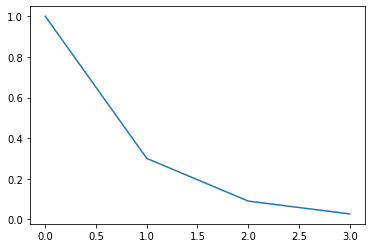

In [47]:
i=2
rho = torch.tensor([ker[i, Dmat[i] == d].unique()[0] for d in range(l+1)]).detach().cpu().numpy()
rho /= rho[0]

from matplotlib import pyplot as plt
plt.plot(rho)
plt.show()

In [48]:
np.roll(rho,1)/rho

array([0.02713229, 3.3279018 , 3.327909  , 3.3279097 ], dtype=float32)

#### Test on arbitrary lambdas

In [53]:
k=1

log_lda = -200*torch.ones(l+1)
log_lda[k] = 1.

kernel.raw_log_lda = torch.nn.Parameter(log_lda)
kernel = kernel.to(output_device)

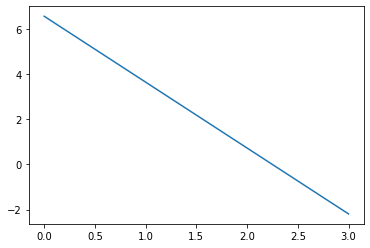

In [54]:
i=1
ker = kernel(seqs1h_test[i].unsqueeze(0), seqs1h_test).evaluate()
rho = torch.tensor([ker[0, Dmat[i] == d].unique()[0] for d in range(l+1)]).detach().cpu().numpy()
# rho /= rho[0]

from matplotlib import pyplot as plt
plt.plot(rho)
plt.show()

In [55]:
rho

array([ 6.5794067,  3.6552582,  0.7310562, -2.193182 ], dtype=float32)

In [56]:
np.roll(rho,1)/rho

array([-0.33334038,  1.7999841 ,  4.9999685 , -0.33333132], dtype=float32)